In [31]:
# ==========================================================
# Microsimulation with Employment Benefit Scenarios
#   Scenario 1: Baseline (no benefit)
#   Scenario 2: £100 cash employment benefit
#   Scenario 3: £50 cash + £50 training
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 0) Load data
# ----------------------------
file_path = "/Users/Nil/Downloads/BENEFITS/WP2/WP2.2/GLEI_micro_simulation_data.xlsx"
data = pd.read_excel(file_path)
output_dir = "/Users/Nil/Micro-Simulation"
import os
os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# 1) Keep & clean relevant columns
# ----------------------------
cols_needed = ["DEMO_ETHNC", "Age", "DEMO_EMPLS", "DEMO_SEX", "DEMO_DISA"]
df = data[cols_needed].copy()

# Ethnicity
eth_map = {
    "White": "White",
    "Black": "Black",
    "Asian": "Asian",
    "Mixed": "Mixed",
    "Other": "Other",
    "Prefer not to say": "Other"
}
df["DEMO_ETHNC"] = df["DEMO_ETHNC"].map(eth_map)

# Employment (harmonize to your categories)
empl_map = {
    "Full-time": "Full-time",
    "Part-time": "Part-time",
    "Unemployed": "Unemployed",
    "Student": "Student",
    "Retired": "Retired",
    "Housewife/husband/person": "House person",
    "Unable to work due to long term illness": "Longterm illness",
    "Prefer not to say": "others",
    "Other": "others"
}
df["DEMO_EMPLS"] = df["DEMO_EMPLS"].map(empl_map)

# Active vs Inactive categories
empl_active_map = {
    "Full-time": "Active",
    "Part-time": "Active",
    "Unemployed": "Inactive",
    "Student": "Inactive",
    "House person": "Inactive",
    "Longterm illness": "Inactive",
    "Retired": "Others",
    "others": "Others"
}
df["DEMO_EMPLS_ACTIVE"] = df["DEMO_EMPLS"].map(empl_active_map)

# Sex
sex_map = {
    "Male": "Male",
    "Female": "Female",
    "Non-binary / third gender": "LGBTQ",
    "Prefer not to say": "Other"
}
df["DEMO_SEX"] = df["DEMO_SEX"].map(sex_map)

# Disability (collapse to Yes / No / Unknown)
df["DEMO_DISA"] = df["DEMO_DISA"].replace({
    "Yes, limited a little": "Yes",
    "Yes, limited a lot": "Yes",
    "No": "No",
    "Prefer not to say": "Unknown",
    "Don't know": "Unknown",
    np.nan: "Unknown"
})

# Age → groups
def age_to_group(age):
    if pd.isna(age):
        return "Unknown"
    try:
        a = int(age)
    except:
        return "Unknown"
    if a <= 18:
        return "Children and adolescents (0–18)"
    elif 18 < a <= 25:
        return "Young adults (18–25)"
    elif 25 < a <= 64:
        return "Adults (26–64)"
    else:
        return "Older adults (65+)"

df["Age_Group"] = df["Age"].apply(age_to_group)

print("✅ Cleaned data preview:")
print(df.head())


✅ Cleaned data preview:
  DEMO_ETHNC  Age  DEMO_EMPLS DEMO_SEX DEMO_DISA DEMO_EMPLS_ACTIVE  \
0      Black   43      others     Male        No            Others   
1      White   28  Unemployed     Male       Yes          Inactive   
2      White   27   Full-time     Male        No            Active   
3      Mixed   31   Full-time     Male        No            Active   
4      Mixed   26   Full-time   Female        No            Active   

        Age_Group  
0  Adults (26–64)  
1  Adults (26–64)  
2  Adults (26–64)  
3  Adults (26–64)  
4  Adults (26–64)  


In [32]:

# ----------------------------
# 2) Scenario definitions (policy levers)
#   Multipliers >1 increase probability for that next-state; <1 reduce.
#   stay_prob = baseline persistence (prob. of staying in same state).
# ----------------------------
SCENARIOS = {
    # 1) Baseline: no employment benefit
    "Baseline (no benefit)": {
        "stay_prob": 0.70,   # how persistent current state is
        "age": {
            "Young adults (18–25)": {"Student": 1.30, "Part-time": 1.15, "Retired": 0.60, "House person": 0.85},
            "Adults (26–64)":       {"Full-time": 1.20, "Unemployed": 0.90},
            "Older adults (65+)":   {"Retired": 1.60, "Full-time": 0.60, "Part-time": 0.80}
        },
        "disability": {
            "Yes": {"Longterm illness": 1.30, "Full-time": 0.85}
        },
        "sex": {
            "Female": {"Part-time": 1.15, "House person": 1.15},
            "Male":   {"Full-time": 1.05}
        },
        # treat all non-White as minority
        "ethnicity_minor": {"Full-time": 0.95, "Part-time": 1.05, "Unemployed": 1.05}
    },

    # 2) Policy:  £100 unemployment benefit
    # Idea: modest improvement in transitions into (especially) part-time work,
    # small reduction in unemployment, a bit more help for disabled people.
    "Benefit £100 cash": {
        "stay_prob": 0.68,  # slightly more movement than baseline
        "age": {
            # young adults: some shift from Unemployed/Student into Part-time
            "Young adults (18–25)": {
                "Part-time": 1.20,
                "Full-time": 1.05,
                "Unemployed": 0.90,
                "Student": 0.95
            },
            # adults: small boost to both full- and part-time, small drop in unemployment
            "Adults (26–64)": {
                "Full-time": 1.15,
                "Part-time": 1.15,
                "Unemployed": 0.88
            },
            # older adults: almost unchanged
            "Older adults (65+)": {
                "Retired": 1.50,
                "Full-time": 0.70,
                "Part-time": 0.90
            }
        },
        "disability": {
            # cash helps a bit with costs (transport, care), so small boost to employment
            "Yes": {
                "Full-time": 1.10,
                "Part-time": 1.10,
                "Longterm illness": 0.95
            }
        },
        "sex": {
            # cash benefit may help women with childcare costs → more part-time
            "Female": {"Part-time": 1.10, "House person": 0.95},
            "Male":   {"Full-time": 1.05}
        },
        "ethnicity_minor": {
            # slight improvement in employment, slight reduction in unemployment
            "Full-time": 1.05,
            "Part-time": 1.05,
            "Unemployed": 0.95
        }
    },

    # 3) Policy:  £50 unemployment benefit + £50 training support
    # Idea: stronger support into jobs (especially full-time) because of training.
    "Benefit £50 cash + £50 training": {
        "stay_prob": 0.63,  # more movement/change than the other two scenarios
        "age": {
            # training makes bigger difference for young adults
            "Young adults (18–25)": {
                "Full-time": 1.25,
                "Part-time": 1.15,
                "Unemployed": 0.80,
                "Student": 0.90
            },
            # adults: strong push into full-time, moderate into part-time, clear drop in unemployment
            "Adults (26–64)": {
                "Full-time": 1.25,
                "Part-time": 1.15,
                "Unemployed": 0.80
            },
            # older adults: little effect, still mostly retired
            "Older adults (65+)": {
                "Retired": 1.55,
                "Full-time": 0.65,
                "Part-time": 0.85
            }
        },
        "disability": {
            # training designed to be inclusive → bigger relative gains for disabled people
            "Yes": {
                "Full-time": 1.20,
                "Part-time": 1.15,
                "Longterm illness": 0.85
            }
        },
        "sex": {
            # training may reduce gender gap slightly
            "Female": {"Part-time": 1.10, "Full-time": 1.05, "House person": 0.90},
            "Male":   {"Full-time": 1.05}
        },
        "ethnicity_minor": {
            # targeted outreach: stronger boost for minorities
            "Full-time": 1.10,
            "Part-time": 1.05,
            "Unemployed": 0.90
        }
    }
}

# ----------------------------
# 3) Transition model (scenario-driven)
# ----------------------------
STATES = [
    "Full-time","Part-time","Unemployed","Student",
    "House person","Longterm illness","Retired","others"
]

def _renorm(d):
    s = sum(d.values())
    if s <= 0:
        n = len(d)
        return {k: 1.0/n for k in d}
    return {k: v/s for k, v in d.items()}

def transition_employment(row, params):
    # 1) baseline persistence
    stay_prob = params["stay_prob"]
    remaining = 1.0 - stay_prob
    base = {s: remaining/(len(STATES)-1) for s in STATES}
    cur = row["DEMO_EMPLS"] if row["DEMO_EMPLS"] in STATES else "others"
    base[cur] = stay_prob

    # 2) age multipliers
    ag = row.get("Age_Group", "Adults (26–64)")
    for k, v in params["age"].get(ag, {}).items():
        base[k] *= v

    # 3) disability multipliers (Yes/No/Unknown; here we set effects only for "Yes")
    disa = row.get("DEMO_DISA", "Unknown")
    for k, v in params["disability"].get(disa, {}).items():
        base[k] *= v

    # 4) sex multipliers
    sex = row.get("DEMO_SEX", "Other")
    for k, v in params["sex"].get(sex, {}).items():
        base[k] *= v

    # 5) ethnicity multipliers (treat non-White as minority for simple illustration)
    eth = row.get("DEMO_ETHNC", "Other")
    if eth in {"Black","Asian","Mixed","Other"}:
        for k, v in params["ethnicity_minor"].items():
            base[k] *= v

    # normalize and draw next state
    probs = _renorm(base)
    nxt = np.random.choice(list(probs.keys()), p=list(probs.values()))
    return nxt



================ Baseline (no benefit) ================


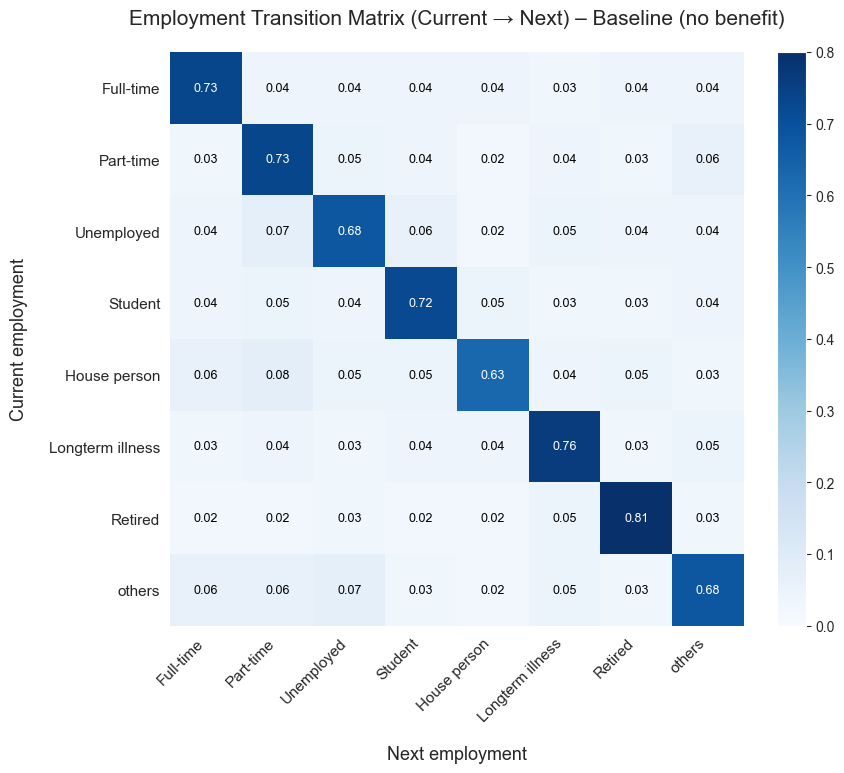

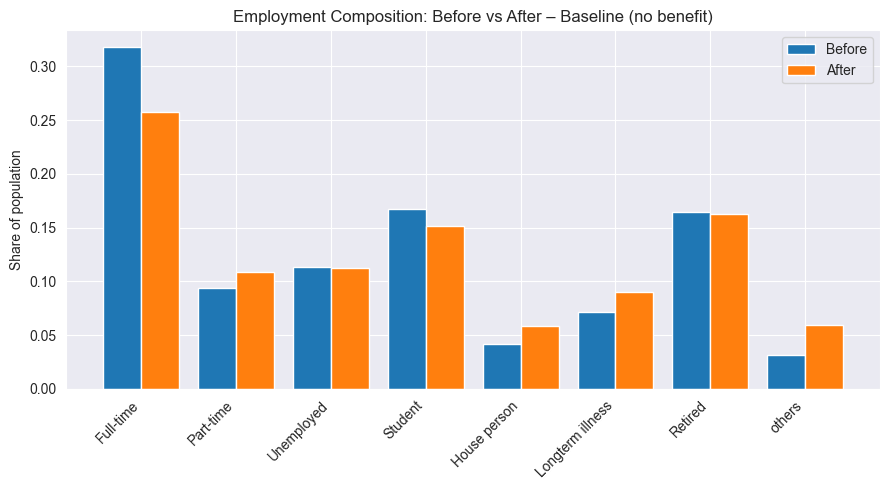

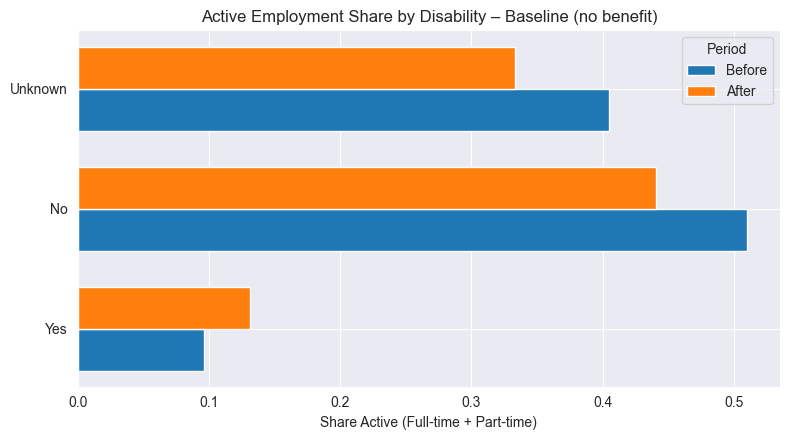


================ Benefit £100 cash ================


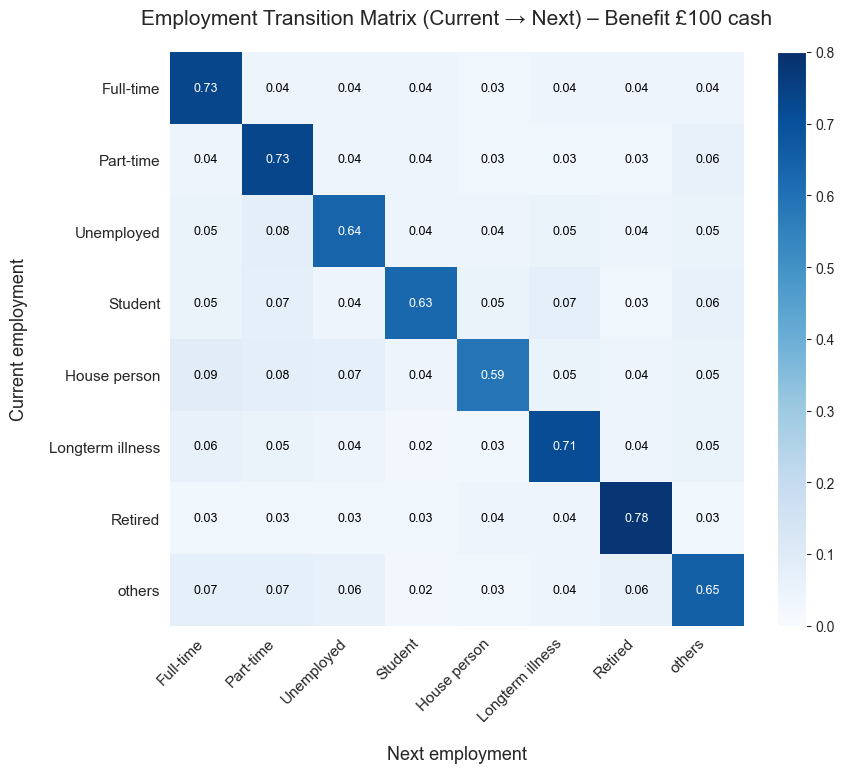

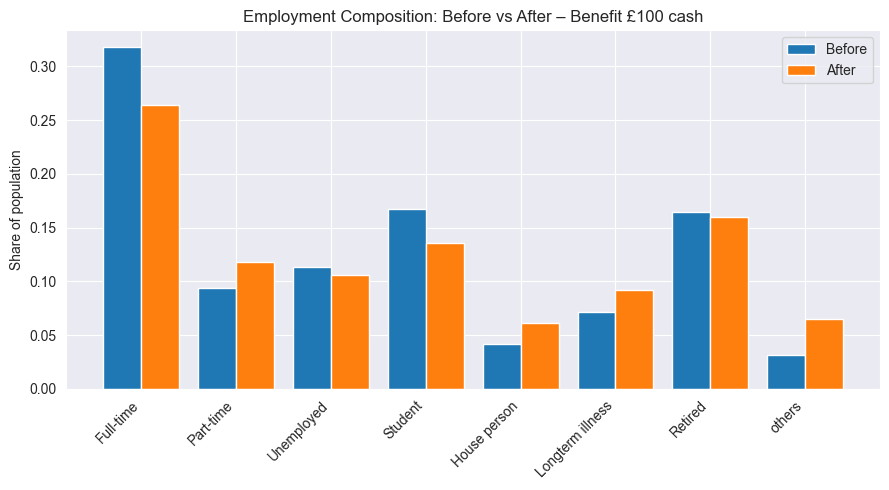

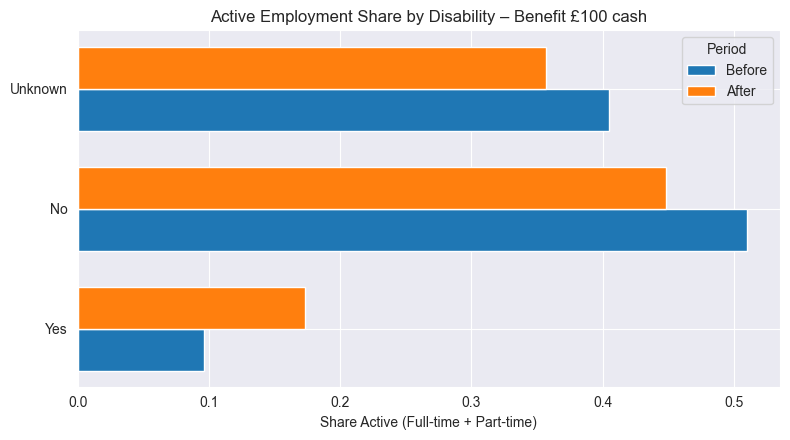


================ Benefit £50 cash + £50 training ================


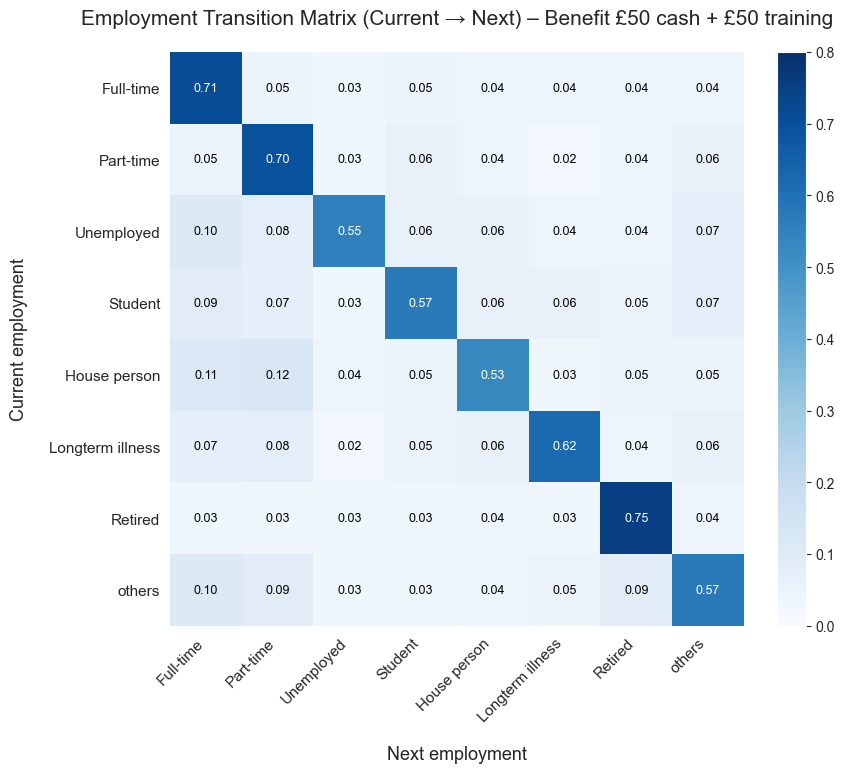

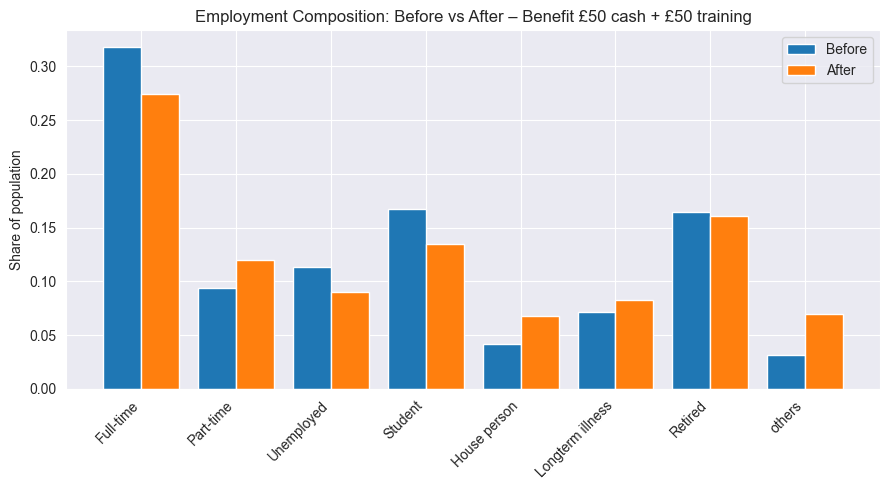

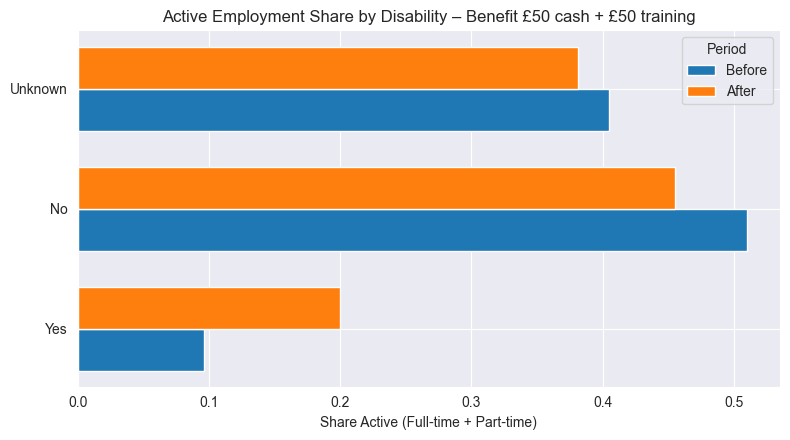


📊 Cross-scenario active share summary:
                                 ActiveShare_overall  ActiveShare_Yes  \
Scenario                                                                
Baseline (no benefit)                          0.366            0.131   
Benefit £100 cash                              0.382            0.173   
Benefit £50 cash + £50 training                0.394            0.200   

                                 ActiveShare_No  ActiveShare_Unknown  
Scenario                                                              
Baseline (no benefit)                     0.441                0.333  
Benefit £100 cash                         0.448                0.357  
Benefit £50 cash + £50 training           0.455                0.381  
Saved: /Users/Nil/Micro-Simulation/scenario_active_share_summary.csv


In [33]:

# ----------------------------
# 4) Simulation runner (one-period before→after per scenario)
# ----------------------------
def run_scenario(df_in, params, years=1, seed=42):
    np.random.seed(seed)
    sim = df_in.copy()
    history = []
    for t in range(1, years+1):
        sim["NEXT_DEMO_EMPLS"] = sim.apply(transition_employment, axis=1, params=params)
        sim["NEXT_DEMO_EMPLS_ACTIVE"] = sim["NEXT_DEMO_EMPLS"].map(empl_active_map)
        sim["Period"] = t
        history.append(sim.copy())
        # roll forward
        sim["DEMO_EMPLS"] = sim["NEXT_DEMO_EMPLS"]
        sim["DEMO_EMPLS_ACTIVE"] = sim["NEXT_DEMO_EMPLS_ACTIVE"]
        sim.drop(columns=["NEXT_DEMO_EMPLS","NEXT_DEMO_EMPLS_ACTIVE"], inplace=True)
    panel = pd.concat(history, ignore_index=True)
    return panel

# ----------------------------
# 5) Run all scenarios
# ----------------------------
scenario_results = {}
for scen_name, params in SCENARIOS.items():
    panel = run_scenario(df, params, years=1, seed=42)
    scenario_results[scen_name] = panel

# ----------------------------
# 6) Outputs per scenario
#    (A) Transition matrix heatmap
#    (B) Before vs After composition
#    (C) Active rate by disability (Before vs After)
# ----------------------------
def plot_transition_matrix(panel, title_suffix):
    tm = pd.crosstab(
        panel["DEMO_EMPLS"],
        panel["NEXT_DEMO_EMPLS"],
        normalize="index"
    ).reindex(index=STATES, columns=STATES).fillna(0).round(2)

    fig, ax = plt.subplots(figsize=(10,8))

    # Plot heatmap with no grid, no edges
    im = ax.imshow(tm.values, cmap="Blues", vmin=0, vmax=0.8)

    # Remove ALL spines (borders)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove gridlines
    ax.grid(False)

    # Set ticks
    ax.set_xticks(range(len(STATES)))
    ax.set_yticks(range(len(STATES)))

    ax.set_xticklabels(STATES, rotation=45, ha="right", fontsize=11)
    ax.set_yticklabels(STATES, fontsize=11)

    ax.set_xlabel("Next employment", fontsize=13, labelpad=15)
    ax.set_ylabel("Current employment", fontsize=13, labelpad=15)

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # Add annotation text
    for i in range(tm.shape[0]):
        for j in range(tm.shape[1]):
            val = tm.values[i, j]
            text_color = "white" if val > 0.35 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    fontsize=9, color=text_color)

    # Extra spacing so text never gets cut off
    plt.tight_layout(pad=3)

    plt.title(f"Employment Transition Matrix (Current → Next) – {title_suffix}", fontsize=15, pad=20)

      # --- SAVE ---
    save_path = os.path.join(output_dir, f"transition_matrix_{title_suffix}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()


def plot_composition(panel, title_suffix):
    before = panel["DEMO_EMPLS"].value_counts(normalize=True).reindex(STATES).fillna(0)
    after  = panel["NEXT_DEMO_EMPLS"].value_counts(normalize=True).reindex(STATES).fillna(0)
    idx = np.arange(len(STATES))
    w = 0.4

    plt.figure(figsize=(9,5))
    plt.bar(idx - w/2, before.values, width=w, label="Before")
    plt.bar(idx + w/2, after.values,  width=w, label="After")
    plt.xticks(idx, STATES, rotation=45, ha="right")
    plt.ylabel("Share of population")
    plt.title(f"Employment Composition: Before vs After – {title_suffix}")
    plt.legend()
    plt.tight_layout()

        # --- SAVE ---
    save_path = os.path.join(output_dir, f"composition_{title_suffix}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()

def plot_active_by_disability(panel, title_suffix):
    before = (
        panel.groupby("DEMO_DISA")["DEMO_EMPLS_ACTIVE"]
              .apply(lambda x: (x=="Active").mean())
              .rename("Before")
    )
    after = (
        panel.groupby("DEMO_DISA")["NEXT_DEMO_EMPLS_ACTIVE"]
              .apply(lambda x: (x=="Active").mean())
              .rename("After")
    )
    compare = pd.concat([before, after], axis=1).reindex(["Yes","No","Unknown"]).fillna(0)

    idx = np.arange(len(compare.index))
    w = 0.35
    plt.figure(figsize=(8,4.5))
    plt.barh(idx - w/2, compare["Before"].values, height=w, label="Before")
    plt.barh(idx + w/2, compare["After"].values,  height=w, label="After")
    plt.yticks(idx, compare.index)
    plt.xlabel("Share Active (Full-time + Part-time)")
    plt.title(f"Active Employment Share by Disability – {title_suffix}")
    plt.legend(title="Period")
    plt.tight_layout()

    save_path = os.path.join(output_dir, f"active_share_by_disability_{title_suffix}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()

# Make plots for each scenario
for scen_name, panel in scenario_results.items():
    print(f"\n================ {scen_name} ================")
    plot_transition_matrix(panel, scen_name)
    plot_composition(panel, scen_name)
    plot_active_by_disability(panel, scen_name)

# ----------------------------
# 7) Cross-scenario comparison table (Active share overall + by disability)
# ----------------------------
def active_share_overall(panel):
    return (panel["NEXT_DEMO_EMPLS_ACTIVE"] == "Active").mean()

def active_share_by_disability(panel):
    return (panel.assign(is_active = panel["NEXT_DEMO_EMPLS_ACTIVE"] == "Active")
                 .groupby("DEMO_DISA")["is_active"]
                 .mean()
                 .reindex(["Yes","No","Unknown"])
                 .rename_axis("Disability"))

summary_rows = []
for scen_name, panel in scenario_results.items():
    row = {"Scenario": scen_name, "ActiveShare_overall": active_share_overall(panel)}
    shares = active_share_by_disability(panel)
    row.update({f"ActiveShare_{k}": v for k, v in shares.items()})
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).set_index("Scenario").round(3)
print("\n📊 Cross-scenario active share summary:")
print(summary)

# Optional: save for your PPT/table
summary_path = os.path.join(output_dir, "scenario_active_share_summary.csv")
summary.to_csv(summary_path)
print("Saved:", summary_path)

